# 1. Import the required libraries

In [1]:
##---------Type the code below this line------------------##
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error

# 2. Data Acquisition & Data Preparation

DJIA 30 Stock Time Series: This dataset contains historical stock data from the Dow Jones Industrial Average (DJIA) index. It is often used for experimenting with LSTM/GRU models to predict stock movements.

https://www.kaggle.com/code/dpamgautam/stock-price-prediction-lstm-gru-rnn/input

In [2]:
# Load the dataset (replace with actual path if you're working offline)
data = pd.read_csv('C:/Users/prosh/OneDrive/Desktop/DNN Assignment II/AABA_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=["Date"])
data.head()


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [3]:
# Checking for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


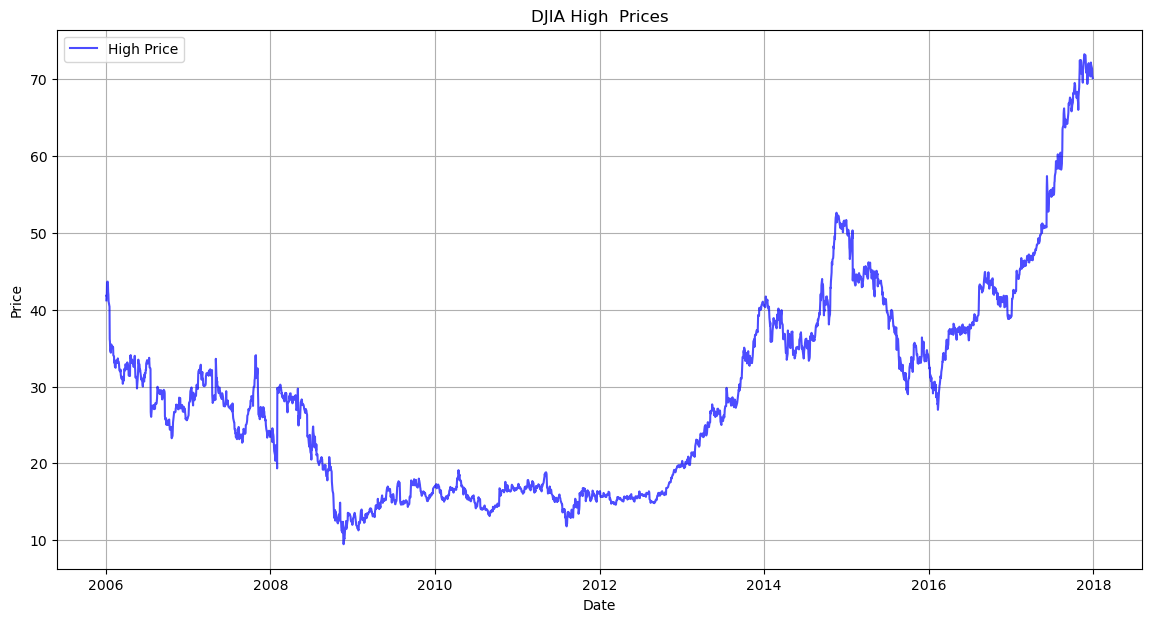

In [4]:
# Plot High
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['High'], label='High Price', color='blue', alpha=0.7)
plt.title('DJIA High  Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

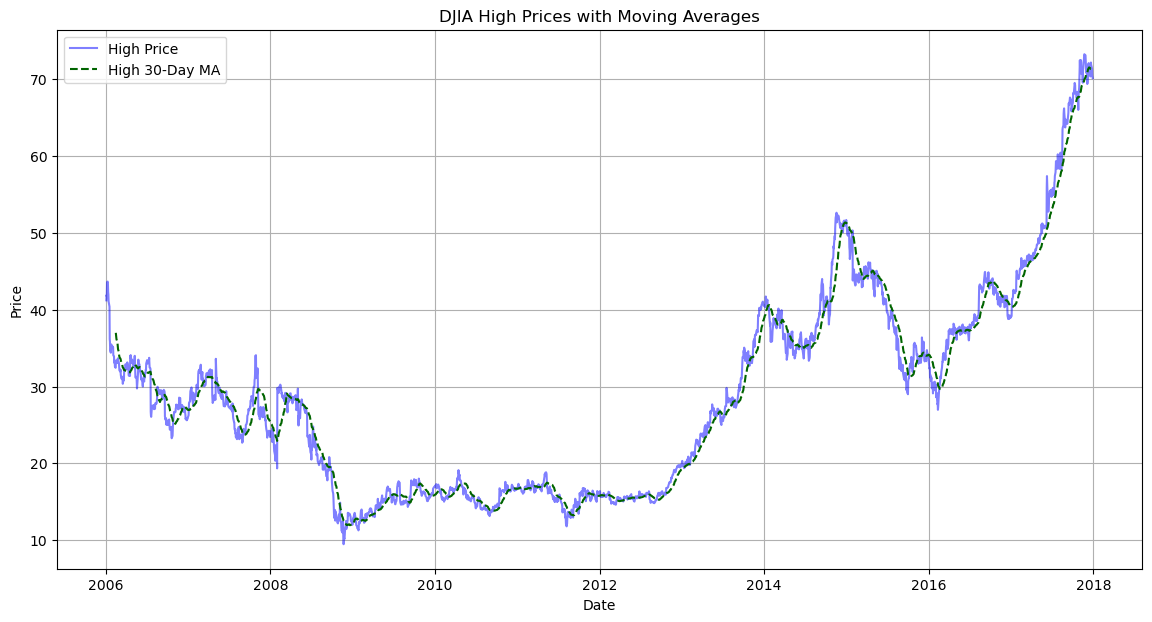

In [5]:
# Calculate moving averages
data['High_MA30'] = data['High'].rolling(window=30).mean()
# Plot High prices with moving averages
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['High'], label='High Price', color='blue', alpha=0.5)
plt.plot(data.index, data['High_MA30'], label='High 30-Day MA', color='darkgreen', linestyle='--')
plt.title('DJIA High Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Select the relevant feature (e.g., closing price of a specific stock)
stock_data = data['Close'].values.reshape(-1, 1)

# Normalize the dataset (LSTM/GRU performs better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Prepare the data for LSTM/GRU
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
print(y)
X, y = create_dataset(scaled_data, time_step)
# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

[0.37621132 0.37199125 0.37214755 ... 0.95201626 0.95514223 0.95139106]


## 3. Deep Neural Network Architecture
## 3.1 Design the architecture that you will be using RNN

In [7]:
# Define RNN model
from keras.layers import SimpleRNN
# Define the model architecture
model_rnn= Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(Dropout(0.3))
model_rnn.add(SimpleRNN(units=50, return_sequences=True))
model_rnn.add(Dropout(0.3))
model_rnn.add(SimpleRNN(units=50, return_sequences=False))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(units=1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_rnn.summary()

C:\Users\prosh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

# 3.2. Training the model

In [14]:
# Train the model
model_rnn.fit(X, y, epochs=40, batch_size=32, validation_split=0.1)

Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9121e-04 - val_loss: 0.0057
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1799e-04 - val_loss: 0.0061
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.5001e-04 - val_loss: 0.0073
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4034e-04 - val_loss: 0.0093
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5221e-04 - val_loss: 0.0071
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.4877e-04 - val_loss: 0.0074
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5492e-04 - val_loss: 0.0076
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5696e-04 - val_loss: 0.0068
Epoch 9/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.4611e-04 - val_loss: 0.0108
Epoch 10/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7127e-04 - val_loss: 0.0094
Epoch 11/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.7054e-04 - val_loss: 0.0055
Epoch 12/40
85/85 ━

# 3.3. Evaluating the model

In [16]:
# Make predictions RNN
predicted_stock_price = model_rnn.predict(X) 

# Inverse transform to original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


Root Mean Squared Error: 2.0187165476864366


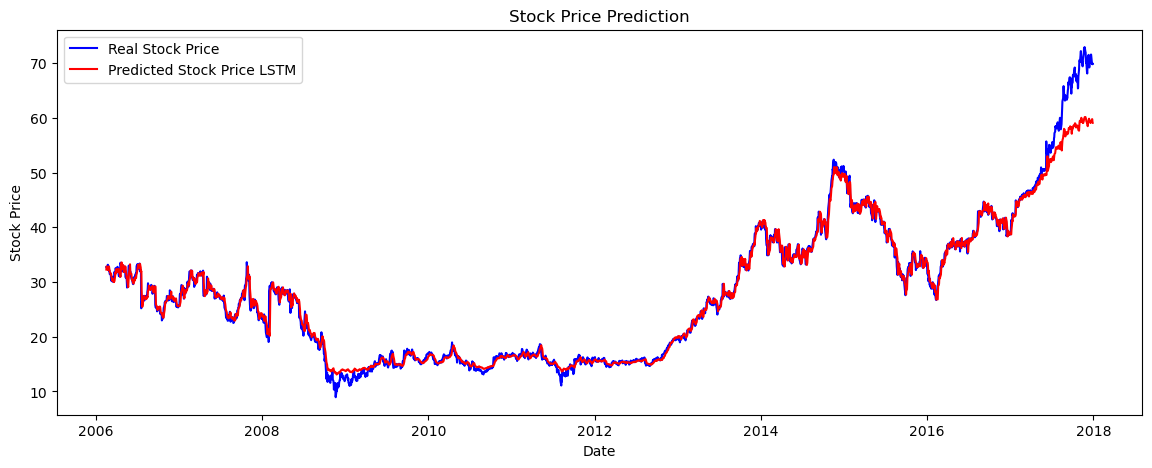

In [17]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data['Close'][time_step + 1:].values, predicted_stock_price))
print(f'Root Mean Squared Error: {rmse}')

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(data.index[time_step + 1:], data['Close'][time_step + 1:], color='blue', label='Real Stock Price')
plt.plot(data.index[time_step + 1:], predicted_stock_price, color='red', label='Predicted Stock Price LSTM')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [18]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

C:\Users\prosh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

# 3.2. Training the model

In [19]:
# Train the model
model_lstm.fit(X, y, epochs=40, batch_size=32, validation_split=0.1)

Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0170 - val_loss: 7.4452e-04
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 9/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 10/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 11/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 12/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss:

# 3.3. Evaluating the model

In [20]:
# Make predictions LSTM
predicted_stock_price = model_lstm.predict(X) 

# Inverse transform to original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Root Mean Squared Error: 1.3348361665834514


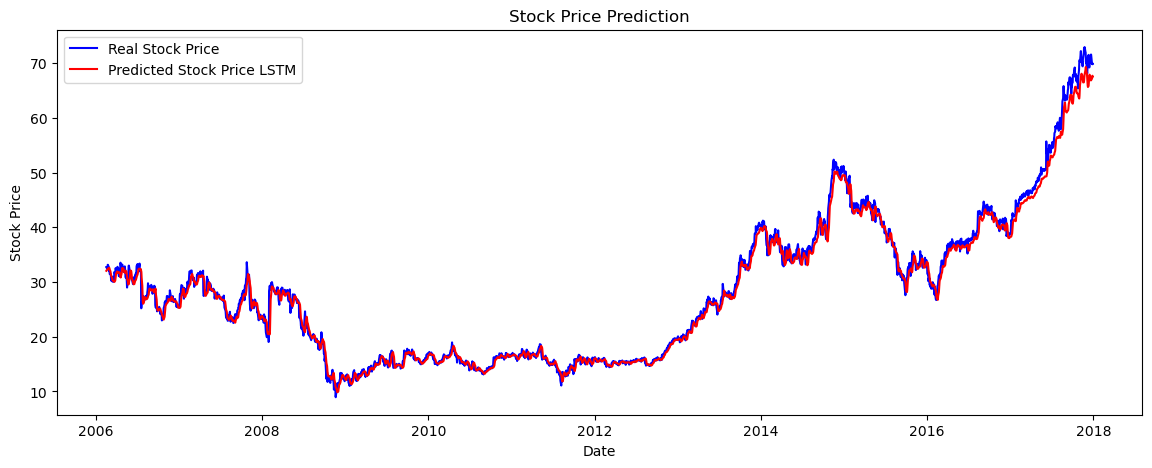

In [21]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data['Close'][time_step + 1:].values, predicted_stock_price))
print(f'Root Mean Squared Error: {rmse}')

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(data.index[time_step + 1:], data['Close'][time_step + 1:], color='blue', label='Real Stock Price')
plt.plot(data.index[time_step + 1:], predicted_stock_price, color='red', label='Predicted Stock Price LSTM')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## 4. Deep Neural Network Architecture
## 4.1 Design the architecture that you will be using GRU

In [22]:
# Define GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(units=50, return_sequences=True))
model_gru.add(Dropout(0.3))
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.summary()

C:\Users\prosh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 30, 50)         │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.2. Training the model

In [23]:
# Train the model
model_gru.fit(X, y, epochs=40, batch_size=32, validation_split=0.1)

Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0156 - val_loss: 3.5077e-04
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0021 - val_loss: 6.5571e-04
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015 - val_loss: 9.3522e-04
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0013 - val_loss: 4.6845e-04
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0012 - val_loss: 5.6439e-04
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 10/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.5539e-04 - val_loss: 0.0019
Epoch 12/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# 4.3. Evaluating the model

In [24]:
# Make predictions LSTM
predicted_stock_price = model_gru.predict(X)  

# Inverse transform to original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


Root Mean Squared Error: 1.0846782991561041


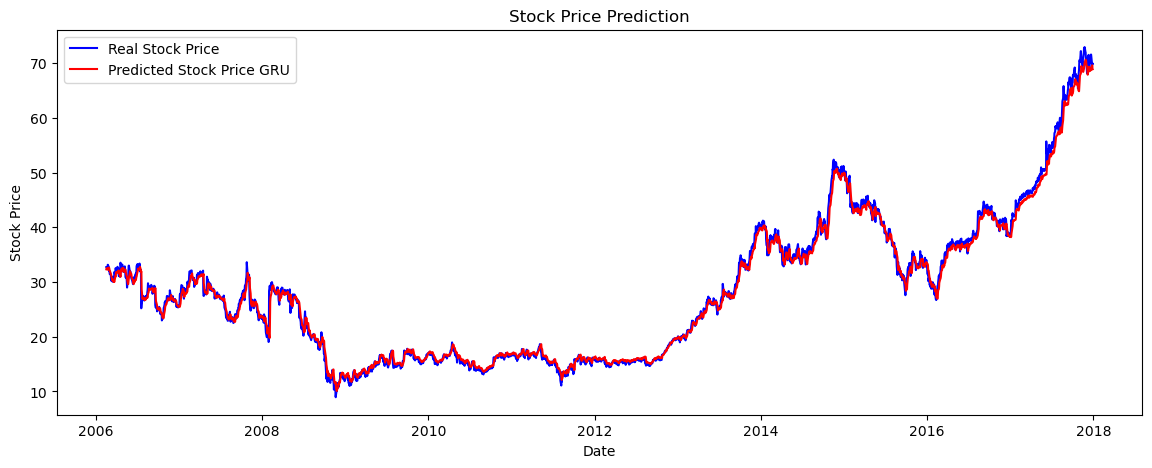

In [25]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(data['Close'][time_step + 1:].values, predicted_stock_price))
print(f'Root Mean Squared Error: {rmse}')

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(data.index[time_step + 1:], data['Close'][time_step + 1:], color='blue', label='Real Stock Price')
plt.plot(data.index[time_step + 1:], predicted_stock_price, color='red', label='Predicted Stock Price GRU')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
